In [1]:
%load_ext autoreload
%env CUDA_VISIBLE_DEVICES=2
import sys
sys.path.append('..')

env: CUDA_VISIBLE_DEVICES=2


In [2]:
%autoreload
from graph_augmented_pt.utils.tensorboard_utils import *

from graphlet_atlas import *
from synthetic_datasets import *
from synthetic_runner import *
from simplicial_manfiolds import *

import matplotlib, pandas as pd
pd.options.mode.chained_assignment = None 
%matplotlib inline

from collections import Counter, defaultdict
import copy, itertools, json, logging, math, os, pickle, scipy, shutil, time, traceback, numpy as np
from tqdm.notebook import tqdm
from scipy.stats import spearmanr

from pathlib import Path

In [3]:
def nCr(n,r):
    f = math.factorial
    return int(f(n) / f(r) / f(n-r))

# Generating Synthetic Data

In [4]:
DO_SUBSAMPLE = False

RAW_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2.txt'
PKL_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat.pkl'
SIMPLEX_ORDER_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/topics_to_try.pkl'
TOPIC_CLIQUE_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/topic_clique.json'

SUBSAMPLE_FILEPATH_TEXT    = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_small.txt'
SUBSAMPLE_FILEPATH_DERIVED = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat_small.pkl'

assert os.path.isfile(RAW_FILEPATH) and os.path.isfile(PKL_FILEPATH)
assert os.path.isfile(SUBSAMPLE_FILEPATH_TEXT) and os.path.isfile(SUBSAMPLE_FILEPATH_DERIVED)

# Source: https://www.kaggle.com/mikeortman/wikipedia-sentences
with open(SUBSAMPLE_FILEPATH_TEXT if DO_SUBSAMPLE else RAW_FILEPATH, mode='r') as f: text_data = f.readlines()

with open(SUBSAMPLE_FILEPATH_DERIVED if DO_SUBSAMPLE else PKL_FILEPATH, mode='rb') as f:
    X, LDA, source_topics, first_topic, sents_by_topic, topic_correlations = pickle.load(f)
n_sents_by_topic = {t: len(sents) for t, sents in sents_by_topic.items()}

with open(SIMPLEX_ORDER_FILEPATH, mode='rb') as f:
    topics_to_try = pickle.load(f)
    
with open(TOPIC_CLIQUE_FILEPATH, mode='r') as f:
    topic_clique_hint = json.loads(f.read())

# Preprocessing Sentences

In [5]:
valid_topics = copy.deepcopy(topic_clique_hint)
topics_cp               = copy.deepcopy(source_topics)
topics_cp_edit          = copy.deepcopy(source_topics)
sentences_cp            = np.array(copy.deepcopy(text_data))
min_sents_per_simplex   = 25
topics_thresh           = 2/3

assert len(topics_cp) > 0
N = len(topics_cp)

top_3_st = time.time()
first_topics  = np.argmax(topics_cp_edit, axis=1)
topics_cp_edit[np.arange(N), first_topics] = 0
second_topics = np.argmax(topics_cp_edit, axis=1)
topics_cp_edit[np.arange(N), second_topics] = 0
third_topics = np.argmax(topics_cp_edit, axis=1)
top_3_end = time.time()

reindex_st = time.time()
top_3 = np.vstack((first_topics, second_topics, third_topics)).T
top_3_probs = copy.deepcopy(source_topics[np.arange(N), [first_topics, second_topics, third_topics]].T)

obs_probability_mass = top_3_probs.sum(axis=1)
assert len(obs_probability_mass) > 0

valid_sents_mask = (obs_probability_mass > topics_thresh)
valid_sents_idx,  = np.where(valid_sents_mask)

topics_cp    = topics_cp[valid_sents_mask]
sentences_cp = sentences_cp[valid_sents_mask]
top_3        = top_3[valid_sents_mask]
top_3_probs  = top_3_probs[valid_sents_mask]
assert len(topics_cp) > 0

reindex_end = time.time()

print(
    f"Dropping {len(source_topics) - len(top_3)} sentences as they lack sufficient probability mass in their top-3.\n"
    f"It took {(reindex_end - reindex_st)/60:.1f} minutes to do that check & drop."
)

cnt_assignments_st = time.time()
all_observed_topic_simplices = Counter(frozenset(t) for t in top_3)
cnt_assignments_end = time.time()

print(
    f"Observe {len(all_observed_topic_simplices)} simplices (of {nCr(100, 3)} total possible) "
    f"in total across {len(topics_cp)} sentences.\n"
    f"It took {(top_3_end - top_3_st)/60:.1f} minutes to get the top 3 topics / sent and "
    f"{(cnt_assignments_end - cnt_assignments_st)/60:.1f} minutes to get the counts."
)

first_filtering_st      = time.time()

valid_simplices         = set(
    k for k, v in all_observed_topic_simplices.items() \
        if (v >= min_sents_per_simplex) and k.issubset(valid_topics)
)
assert len(valid_simplices) == nCr(len(valid_topics), 3)

sufficiently_dense_mask = [frozenset(row) in valid_simplices for row in top_3]

sentences_cp            = sentences_cp[sufficiently_dense_mask]
topics_cp               = topics_cp[sufficiently_dense_mask]
top_3                   = top_3[sufficiently_dense_mask]
top_3_probs             = top_3_probs[sufficiently_dense_mask]
valid_sents_idx         = valid_sents_idx[sufficiently_dense_mask]
first_filtering_end     = time.time()

print(
    f"After filtering out insufficiently dense or incomplete simplices, "
    f"we have {len(valid_simplices)}/{len(topics_cp)} "
    f"simplices / sentences, respectively. This process took "
    f"{(first_filtering_end - first_filtering_st)/60:.1f} minutes"
)

normalization_st = time.time()
normalized = np.divide(top_3_probs, top_3_probs.sum(axis=1)[:, np.newaxis])
entropy    = -(normalized * np.log(normalized)).sum(axis=1)
entropy_per_simplex = defaultdict(list)
for i, (e, ts) in enumerate(zip(entropy, top_3)): entropy_per_simplex[frozenset(ts)].append(e)
    
agg_entropy_per_simplex = {
    k: (np.min(es), np.max(es), np.histogram(es)) for k, es in entropy_per_simplex.items()
}
normalization_end = time.time()

print(f"Normalizing & computing entropy took {(normalization_end - normalization_st)/60:.1f} minutes")

Dropping 2178743 sentences as they lack sufficient probability mass in their top-3.
It took 1.0 minutes to do that check & drop.
Observe 158547 simplices (of 161700 total possible) in total across 5693082 sentences.
It took 0.1 minutes to get the top 3 topics / sent and 0.2 minutes to get the counts.
After filtering out insufficiently dense or incomplete simplices, we have 816/248694 simplices / sentences, respectively. This process took 0.2 minutes
Normalizing & computing entropy took 0.0 minutes


# Experiments

## Manifolds We'll Study

### Sphere

Manifold has 16 simplices


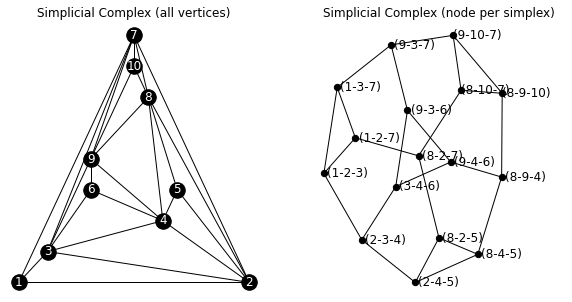

In [6]:
# Simple:
#     ()-
#    / \ \
#   /  \ /*
#  ()--()
# 
# Which is given by (1, 2, 3), (2, 3, 4), (1, 3, 4), (1, 2, 4)
# 
# To make it a bit bigger, we triangulate each of the faces of the tetrahedron separately.
# 
#       (1)-
#      /  \ \
#     /   \ /(7)
#    (2)--(3)-\\(10)
#   /  \  / \ \/
#  /   \ /  \ /(9)
# (5)--(4)--(6)


sphere_kwargs = {'simplices': [
    (1, 2, 3), (2, 3, 4), (2, 4, 5), (3, 4, 6),
    (1, 2, 7), (2, 7, 8), (2, 5, 8), (7, 8, 10),
    (1, 3, 7), (3, 7, 9), (3, 6, 9), (7, 9, 10),
    (8, 9, 10), (4, 8, 9), (4, 5, 8), (4, 6, 9),
]}
M_sphere = LabeledSimplicialManifold(**sphere_kwargs)
M_sphere.display();

## Setup

In [7]:
logging.getLogger('lightning').setLevel(logging.ERROR)

DO_OVERWRITE       = True
gml_head           = EUCLIDEAN_DISTANCE
gml_weight = 0.1
point_weight = 1 - gml_weight

exp_dir = exp_dir = Path("/crimea/graph_augmented_pt/runs/synthetic_reproductions/manifolds_v2")
if not exp_dir.exists(): os.makedirs(exp_dir)
    
manifold_name, manifold_kwargs = 'sphere', sphere_kwargs
dataset_size                   = 300

manifold_dir = exp_dir / manifold_name

dataset_dir = manifold_dir / f"dataset_size_{dataset_size:d}"
if not dataset_dir.exists(): os.makedirs(dataset_dir)
        
ds_graph_gen_kwargs = dict(
    manifold_kwargs         = manifold_kwargs,
    seed                    = 1600,
    subsample_data          = -1,
    num_samples_per_simplex = 75,
    dataset_size            = dataset_size,
    batch_size              = 16,
)
        
with open(dataset_dir / "graph_gen_kwargs.json", mode='w') as f:
    f.write(json.dumps(ds_graph_gen_kwargs))

graph_gen_kwargs=dict(
    source_sentences               = sentences_cp,
    source_topic_probabilities     = topics_cp,
    simplex_probabilities          = normalized,
    simplex_entropies              = entropy,
    topic_simplices                = top_3,
    source_original_sentence_idxs  = valid_sents_idx,
    topic_clique                   = valid_topics,
    agg_entropy_per_simplex        = agg_entropy_per_simplex,
    manifold_radius_graph_r        = 0.2,
    tqdm                           = tqdm,
    **ds_graph_gen_kwargs
)

D = ManifoldNearestNeighborDataset(**graph_gen_kwargs)

Generating Distances & Graph


{'Topics': (0.8732949735449733, 0.19191546806455206)}


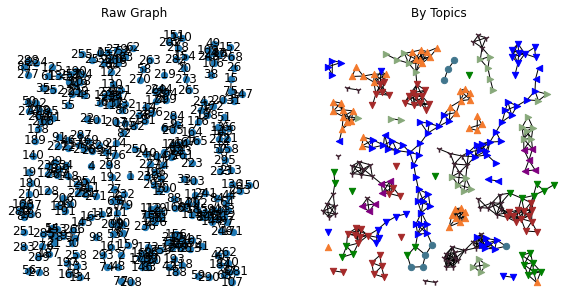

In [8]:
r = 0.2
r_dir = dataset_dir / f"rNN_r_{str(r)}"
D.num_dataloader_workers = 0 # For synthetic data, this is way faster.

print(D.homophily_measure()[0])
D.display(do_print=False)

In [9]:
import pickle
def enpickle(obj, filepath):
    with open(filepath, mode='wb') as f: return pickle.dump(obj, f, 4)
enpickle(D, dataset_dir / 'dataset.pkl')

## Runs

In [10]:
def run(gml_weight):
    output_dir = r_dir / f"gml_weight_{gml_weight}"
    if output_dir.exists():
        if DO_OVERWRITE: shutil.rmtree(output_dir)

    accum, run_model, model_metadata, dataset_seeds = run_synthetic(
        encoder_hidden_size           = 256,
        encoder_num_hidden_layers     = 3,
        encoder_num_attention_heads   = 4,
        encoder_intermediate_size     = 256,
        output_dir                    = output_dir,
        synthetic_dataset             = D,
        gml_head                      = gml_head,
        gml_weight                    = gml_weight,
        point_weight                  = point_weight,
        print_first                   = 0,
        do_plot                       = False,
        tqdm                          = lambda *a, **kw: tqdm(*a, **kw, leave=False),
        num_epochs                    = 1500,
        num_samples                   = 3,
        re_gen_data_in_between        = True,
        neighbor_prediction_eval_freq = 100,
        weights_summary               = None,
        do_checkpointing              = False,
        progress_bar_refresh_rate     = 0,
        do_overwrite                  = DO_OVERWRITE,
        eval_batch_size               = 16,
    )

    res_dict = {k: accum.mean_std(k) for k in accum.run_stats}

    return res_dict, run_model[0]

In [11]:
res_dict, model = run(gml_weight = 0.1)
res_dict

Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


{'labels/Topics Accuracy': (0.6, 0.04838120234906052),
 'labels/Topics AUROC': (0.8218016114600385, 0.021883849492030285)}

In [12]:
torch.cuda.empty_cache()

In [13]:
res_dict, model = run(gml_weight = 0)
res_dict

Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Generating Distances & Graph


/crimea/conda_envs/graph_augmented_pt_2/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


{'labels/Topics Accuracy': (0.16666666666666666, 0.012472191289246473),
 'labels/Topics AUROC': (0.5312498764519363, 0.007633519896604078)}